In [1]:
!nvidia-smi

Thu May 13 10:45:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 28%   48C    P0    63W / 250W |    389MiB / 11175MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 53%   

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D as MaxPooling2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import add, concatenate
import six

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
!ls /tmp

Notebooks	 __pycache__	      tmp23uafz9t.py  tmpv9y_q_a2.py
Pipfile		 data		      tmp5ewht9o8.py  tmpw5a0y9da.py
Pipfile.lock	 data_collection_vio  tmpj9t2h725     tmpxcwdhfye.py
README.md	 tmp082p5vm3.py       tmpmy4pxrsc.py
ReadingMaterial  tmp1cczk17o.py       tmpruafdkjf.py


In [5]:
import pathlib
import os

In [6]:
data_dir = pathlib.Path('/tmp/data/nyu2_train')

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
img_height = 128
img_width = 128

In [9]:
def get_depth(file_path):
    return tf.strings.regex_replace(file_path, 'jpg', 'png')

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3) / 255
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width], antialias=True)

def decode_png(depth):
    depth = tf.image.decode_png(depth, channels=1)
    d_mean = tf.experimental.numpy.nanmean(depth)
    depth = tf.experimental.numpy.where(depth == 0, d_mean, depth)
    depth = depth / 255
    return tf.image.resize(depth, [img_height, img_width], antialias=True)

def process_path(file_path):
    depth_path = get_depth(file_path)
    # load the raw data from the file as a string
    rgb = tf.io.read_file(file_path)
    depth = tf.io.read_file(depth_path)
#     print(file_path)
#     print(depth_path)
    rgb = decode_img(rgb)
    depth = decode_png(depth)
    return rgb, depth

In [10]:
def configure_for_performance(ds, batch_=32):
#     ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

In [12]:
img_count = tf.data.experimental.cardinality(list_ds).numpy()
print(img_count)

50688


In [13]:
val_size = int(img_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [14]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

40551
10137


In [15]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## ResNet34

In [17]:


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
#     print(stride_width, stride_height)
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
#     print(init_strides);
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'channels_first':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        model = Model(inputs=input, outputs=block)
        return model

    @staticmethod
    def build_resnet_18(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [3, 4, 6, 3])

## ResNet34 Unet Model

In [18]:
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/unet/models.py

def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [19]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid', name='mymodel',
               **kwargs):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
#     print(skip_layers)
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        if i < len(skip_layers):
#             print(backbone.layers[skip_layers[i]])
#             print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))
#         print(filters)

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)
    model = Model(input, x, name=name)

    return model

In [20]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', name='mymodel', **kwargs):

    backbone = ResnetBuilder.build_resnet_34(input_shape=input_shape)

    skip_connections = list([97,54,25])  # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, name=name, **kwargs)
#     model.name = 'u-resnet34'

    return model

## Build Res34Unet

In [17]:
# %load_ext autoreload

In [18]:
# %autoreload 1

In [21]:
model = UResNet34(input_shape=(128,128,3), name='u-resnet34-2')

In [19]:
# %aimport resnet34unet

In [23]:
# from resnet34unet import ResNet34Unet

In [24]:
# m = resnet34unet.ResNet34Unet((128,128,3))

In [25]:
# model = m.model

In [26]:
model.summary()

Model: "resnet-34-unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 64, 64, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 64, 64, 64)   0           batch_normalization_33[0][0]     
_____________________________________________________________________________________

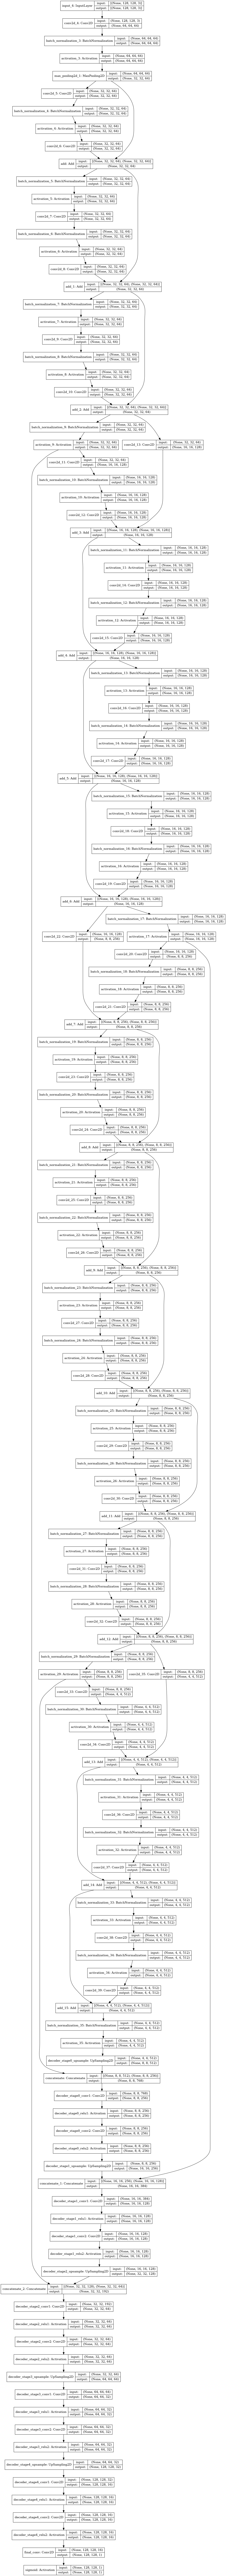

In [35]:
keras.utils.plot_model(model, show_shapes=True, to_file='resnet35-unet.png')

In [27]:
def ssmi_loss1(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
#     y_true = tf.expand_dims(y_true, -1)
#     y_pred = tf.expand_dims(y_pred, -1)
    ssim = tf.image.ssim(y_true, y_pred, 
                            max_val=10.0, 
                            filter_size=11,
                            filter_sigma=1.5,
                            k1=0.01,
                            k2=0.03)
    loss1 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # loss3 = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    loss2 = tf.reduce_mean(1-ssim)
    return loss2*0.7+loss1*0.3

In [28]:
model.compile(optimizer='adam', loss=ssmi_loss1, metrics=['acc'])

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/resnet34-2")

In [32]:
savebest = tf.keras.callbacks.ModelCheckpoint('./tmp/resnet34-2',
                                monitor='loss',
                               save_freq='epoch',
                                save_best_only=True)

In [33]:
# Test Import module

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
# model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1, callbacks=[tensorboard_callback, savebest])

Epoch 1/2
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - ETA: 0s - loss: 0.2396 - acc: 3.4797e-09(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - 393s 230ms/step - loss: 0.2394 - acc: 3.4781e-09 - val_loss: 0.0619 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34-2/assets
Epoch 2/2
1268/1268 [==============================] - 136s 106ms/step - loss: 0.0402 - acc: 3.3852e-09 - val_loss: 0.0594 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34-2/assets


In [41]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=1, callbacks=[tensorboard_callback, savebest])

Epoch 1/200
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - ETA: 0s - loss: 0.2287 - acc: 0.0000e+00(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - 417s 243ms/step - loss: 0.2285 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34/assets
Epoch 2/200
1268/1268 [==============================] - 134s 104ms/step - loss: 0.0402 - acc: 3.4310e-09 - val_loss: 0.0558 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34/assets
Epoch 3/200
1268/1268 [==============================] - 134s 104ms/step - loss: 0.0382 - acc: 3.4662e-09 - val_loss: 0.0824 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34/assets
Epoch 4/200
1268/1268 [==============================] - 134s 104ms/step - loss: 0.0358 - acc: 3.3409e-09 - val_loss: 0.0549 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: .

In [43]:
test_img = '/tmp/data/nyu2_test/00016_colors.png'
depth_img = '/tmp/data/nyu2_test/00016_depth.png'

In [44]:
import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img)

In [45]:
dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)

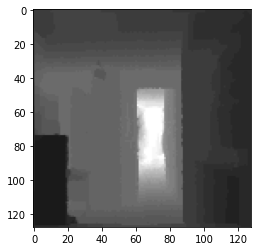

In [168]:
plt.imshow(dimg)

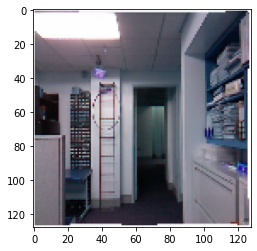

In [169]:
plt.imshow(img)

In [170]:
img.shape

(128, 128, 3)

In [46]:
preds = model.predict(np.expand_dims(img / 255.0, axis=0))

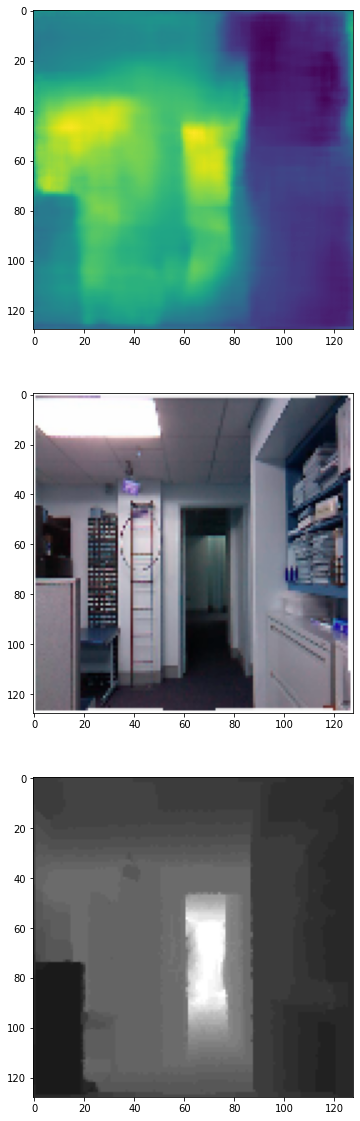

In [47]:
plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

## Running Predict on DIML single image as test

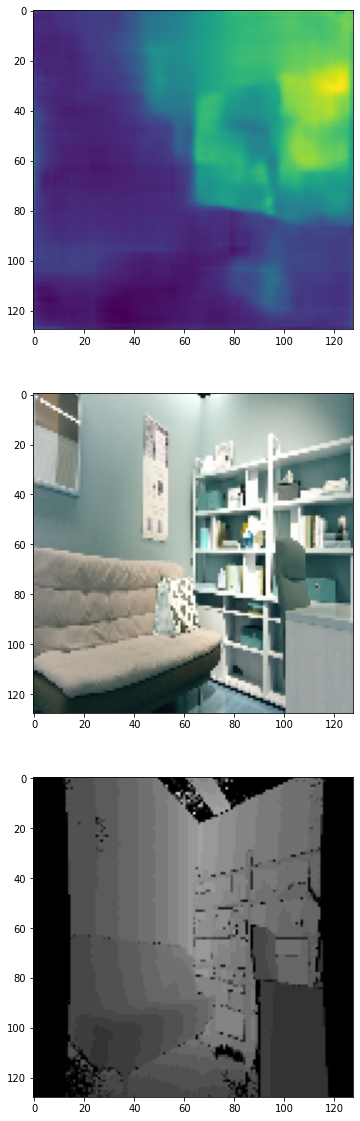

In [48]:
test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_00_160216_122936_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_00_160216_122936_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

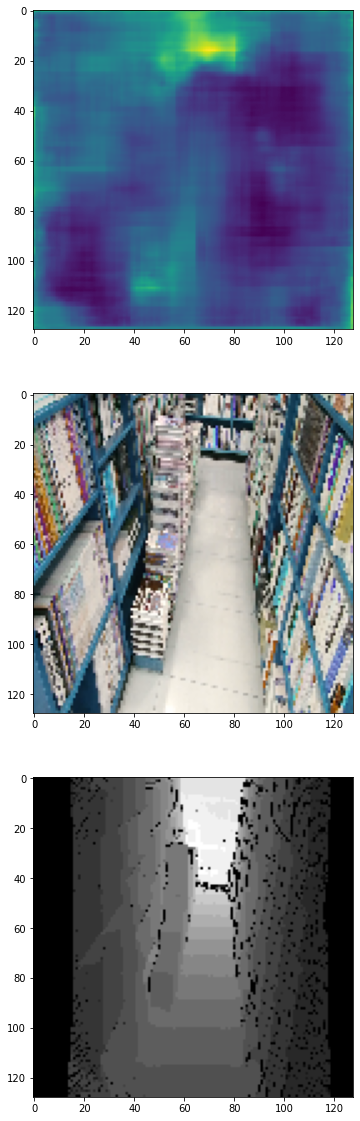

In [49]:
# in_03_160317_172443_c.png

test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_03_160317_172443_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_03_160317_172443_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg,  cmap=plt.cm.viridis)

In [31]:
keras.__version__

'2.4.3'

In [32]:
import keras
model = keras.models.load_model('./tmp/resnet34')

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,3,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]

In [ ]:
modelsav